In [1]:
import subprocess as sp
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns  # for aesthetic

import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
import neuraltda.simpComp as sc
import numpy as np
import tempfile
import h5py as h5
import glob
import os
from importlib import reload
import tqdm
%matplotlib inline

sns.set_style('ticks')

import datetime
daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)

/home/brad/DailyLog/20170915/


/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
winsize = 10.0
segment_info = [0, 0]
pover = 0.5
block_path = '/home/brad/krista/B1083/P03S03/'
#block_path = '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site05_Z3500__B1056_cat_P01_S05_1/'
#block_path = '/home/brad/krista/B1235/P02S01/'
# Bin data
bfdict = tp2.dag_bin(block_path, winsize, segment_info, cluster_group=['Good'], dt_overlap=pover*winsize, comment='ForSCM')
bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
print(bdf)

/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForSCM/20170829T191155Z-10.0-5.0.binned


In [12]:
thresh = 13.0


nperms=None
ncellsperm=0
dims = [0,1,2,3]
twin = np.linspace(0, 6000, 10)
windt = winsize
dtovr=pover*windt

stim_dict = {}
stim_shuffled_dict = {}
stim_scm_dict = {}
stim_betticurve_dict = {}
stim_shuffled_betticurve_dict = {}

In [13]:
reload(tp2)
# compute real and shuffled betti curves - TrialAverage
print('Computing trial average')
(bc_tavg, t, tms) = tp2.compute_trialaverage_betti_curves('ForSCMControl', block_path, bdf, thresh, nperms, ncellsperm, dims, twin, windt, dtovr)
(bc_tavg_shuff, t, tms) = tp2.compute_trialaverage_betti_curves('ForSCMControl-Shuffle', block_path, bdf, thresh, nperms, ncellsperm, dims, twin, windt, dtovr, shuffle=True)

Computing trial average


In [ ]:
bc['I_40k'].shape

In [ ]:
reload(tp2)
with h5.File(bdf, 'r') as bdff:
    stims = bdff.keys()
    for stim in stims:
        print(stim)
        stim_poptens = tp2.extract_population_tensor(bdf, stim)
        ntrials = tp2.num_trials(stim_poptens)
        stim_scm_dat= []
        for trial in tqdm.tqdm(range(ntrials)):
            scm_bettis = tp2.calc_scm_betti_distribution(stim_poptens, thresh, trial, nsamples)
        
            stim_scm_dat.append(scm_bettis)
        stim_scm_dict[stim] = stim_scm_dat

In [67]:
def plot_scm_distribution(scm_bettis, trial, bettinum, maxbin=200, ax=None, **kwargs):
    nmaxtot = 0
    scm_trial_bettis = scm_bettis[trial]
    bettivals = []
    try:
        for x in scm_trial_bettis:
            try:
                bettivals.append(x[0][bettinum])
            except IndexError:
                bettivals.append(0)
    except IndexError:
        bettivals = [x[bettinum] for x in scm_trial_bettis]
    bettivals2 = []
    for x in bettivals:
        if type(x) is not list:
            bettivals2.append(x)
        else:
            bettivals2.append(x[0])
    #print(bettivals)
    maxbettival = np.amax(bettivals2)
    maxbin = round(1.5*maxbettival)
    print(maxbin)
    bins = np.arange(maxbin)
    (n, bins2, ptaches) = ax.hist(bettivals2, bins, normed=True, stacked=True, **kwargs)
    #print(n)
    nmax = np.amax(n)
    nmaxtot = np.amax([nmax, nmaxtot])
    nmaxx = np.amax(bins)
    return (nmaxtot, nmaxx)

def plot_scm_distrib(scm_bettis, bettinum, maxbin=200, ax=None, **kwargs):
    
    nmaxtot = 0
    
    bettis = scm_bettis[:, 0, bettinum]
    bettis = bettis[bettis >=0]
    #print(bettis)
    maxbettival = np.amax(bettis)
    maxbin = round(1.5*(maxbettival+1))
    bins = np.arange(maxbin)
    (n, bins2, ptaches) = ax.hist(bettis, bins, normed=True, stacked=True, **kwargs)
    #print(n)
    nmax = np.amax(n)
    nmaxtot = np.amax([nmax, nmaxtot])
    nmaxx = np.amax(bins)
    return (nmaxtot, nmaxx)

In [ ]:
# average over all trials
import tqdm
nsamples = 200

stim_dict = {}
stim_shuffled_dict = {}
stim_scm_dict = {}
stim_betticurve_dict = {}
stim_shuffled_betticurve_dict = {}
with h5.File(bdf, 'r') as bdff:
    stims = bdff.keys()
    for stim in tqdm.tqdm(stims):
        #print(stim)
        trial=0
        stim_poptens = tp2.extract_population_tensor(bdf, stim)
        ntrials = tp2.num_trials(stim_poptens)
        stim_scm_dat= []
        stim_trialavg_poptens = np.mean(stim_poptens, axis=2)[:, :, np.newaxis]     
        scm_bettis = tp2.calc_scm_betti_distribution(stim_trialavg_poptens, thresh, trial, nsamples)
        stim_scm_dict[stim] = scm_bettis


In [ ]:
import pickle
with open(os.path.join(block_path,'scm_control_save_trialvg_thresh13.pkl'), 'wb') as f:
    pickle.dump(stim_scm_dict, f)

In [62]:
import pickle
with open(os.path.join(block_path,'scm_control_save_trialvg.pkl'), 'rb') as f:
    stim_scm_dict = pickle.load(f)


In [ ]:
int([-1])

[ 5.83333333  0.          0.          0.          0.          0.
  0.66666667  0.          0.          0.          0.          0.          0.
  0.13333333  0.          0.          0.          0.          0.
  0.03333333]
[  2.  50.  72.   4.]
[ 19.6   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.4]
[  2.  58.  41.   3.]
[ 4.3    0.     0.     0.     0.     0.575  0.     0.     0.     0.     0.075
  0.     0.     0.     0.     0.025  0.     0.     0.     0.025]
[  3.  42.  42.   0.]


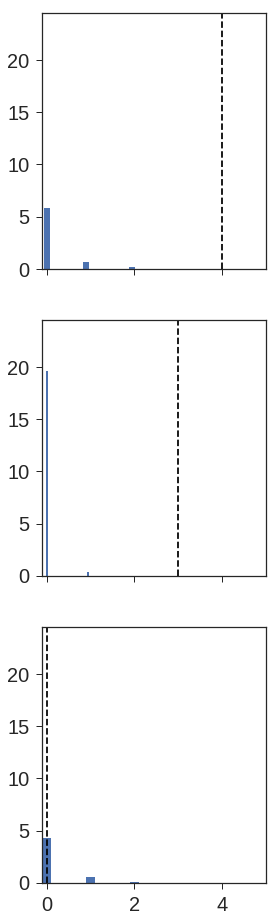

In [7]:
f, axs = plt.subplots(3, 1, sharey=True, sharex=True, figsize=(4, 16))
betti_num = 3
stims = list(bc_tavg.keys())[1:4]
my = 0
nmaxyt = 0
nmaxxt = 0
for ax, stim in zip(axs.flatten(), bc_tavg.keys()):
    final_bettis = bc_tavg[stim][:, -1, 0]
   
    #final_bettis = stim_betticurve_dict[stim][-1]
    b = final_bettis[betti_num]
    ax.plot([b, b], [0, 100], 'k--')
    (nmaxy, nmaxx) = plot_scm_distribution([stim_scm_dict[stim]], 0, betti_num, ax, align='left', histtype='stepfilled')
    nmaxyt = np.amax([nmaxy, nmaxyt])
    nmaxxt = np.amax([nmaxx, nmaxxt])
    print(final_bettis)

    #ax.set_title(stim)
    
    ax.set_xlim([-0.1, 1.25*nmaxxt])
    ax.set_ylim([0, 1.25*nmaxyt])
    ax.tick_params(labelsize=20)
plt.savefig(os.path.join(figsavepth, 'SCMControlB1083_betti{}.eps'.format(betti_num)))

3.0
[  2.  50.  72.   4.]
4.0
[  2.  58.  41.   3.]
4.0
[  3.  42.  42.   0.]
111.0
[  2.  50.  72.   4.]
141.0
[  2.  58.  41.   3.]
99.0
[  3.  42.  42.   0.]
310.0
[  2.  50.  72.   4.]
201.0
[  2.  58.  41.   3.]
308.0
[  3.  42.  42.   0.]
4.0
[  2.  50.  72.   4.]
2.0
[  2.  58.  41.   3.]
6.0
[  3.  42.  42.   0.]


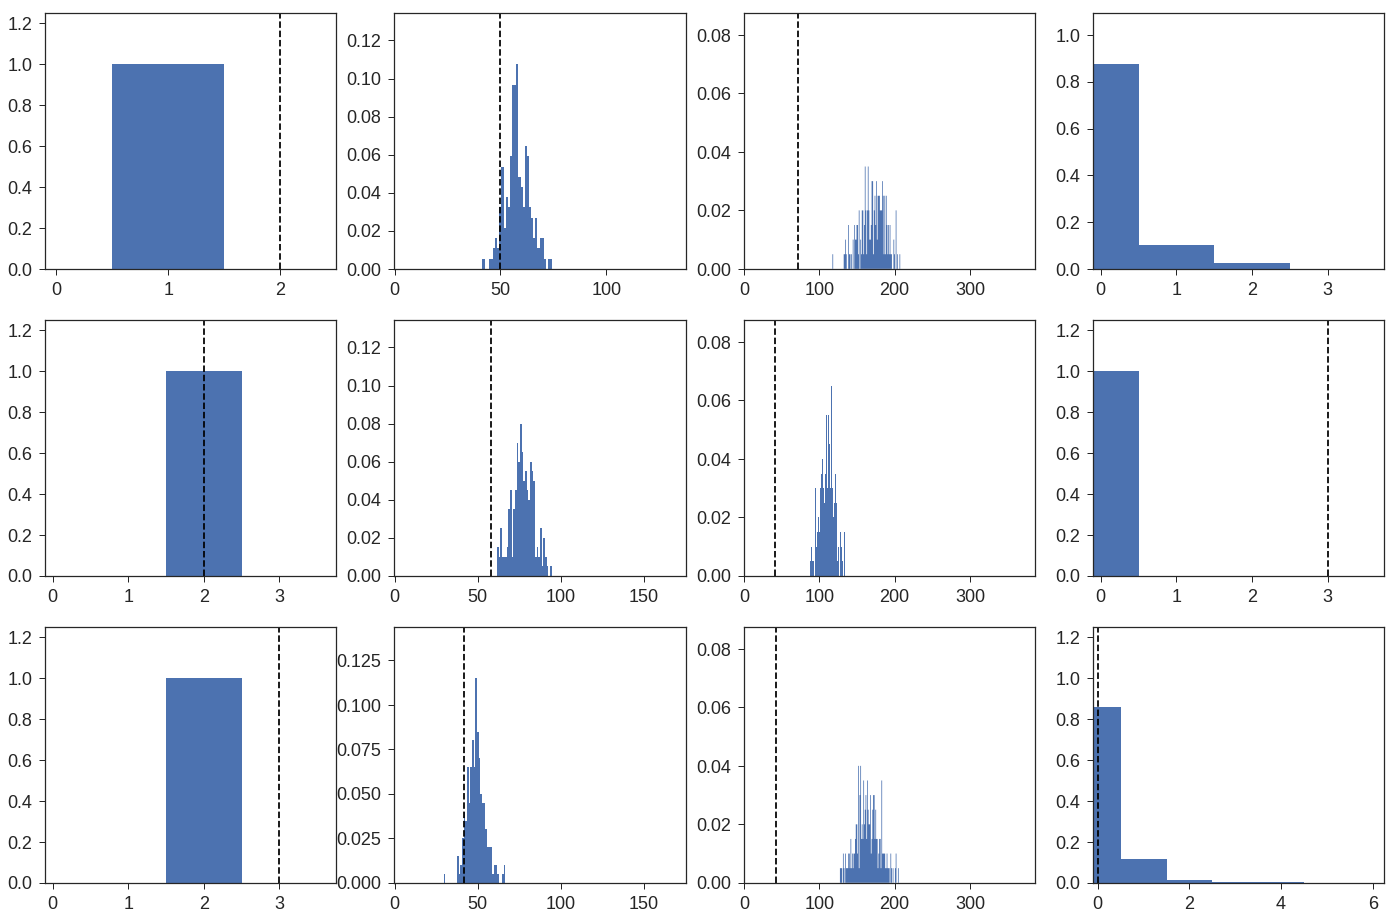

In [72]:
f, axs = plt.subplots(3, 4,figsize=(24, 16))
betti_num = 3
bettis = [0,1,2,3]
stims = list(bc_tavg.keys())[1:4]
my = 0
for betti_num in bettis:
    nmaxyt = 0
    nmaxxt = 0
    bettiax = axs.flatten()[4*np.array([0,1,2]) + betti_num]
    for ax, stim in zip(bettiax, bc_tavg.keys()):
        final_bettis = bc_tavg[stim][:, -1, 0]
   
        #final_bettis = stim_betticurve_dict[stim][-1]
        b = final_bettis[betti_num]
        ax.plot([b, b], [0, 100], 'k--')
        (nmaxy, nmaxx) = plot_scm_distribution([stim_scm_dict[stim]], 0, betti_num, ax=ax, align='left', histtype='stepfilled')
        nmaxyt = np.amax([nmaxy, nmaxyt])
        nmaxxt = np.amax([nmaxx, nmaxxt])
        print(final_bettis)

    #ax.set_title(stim)
    
        ax.set_xlim([-0.1, 1.25*nmaxxt])
        ax.set_ylim([0, 1.25*nmaxyt])
        ax.tick_params(labelsize=18)
plt.savefig(os.path.join(figsavepth, 'SCMControlB1083_bettiAll.eps'.format(betti_num)))

In [ ]:
#compute pvalues
dims2 = [0,1,2]
for stim in bc_tavg.keys():
    for dim in dims2:
        final_betti = bc_tavg[stim][dim, -1, 0]
        scm_dist = np.array(stim_scm_dict[stim])
        scm_dist = [x[0][dim] for x in scm_dist]
        m = np.mean(scm_dist)
        N = len(scm_dist)
        if final_betti > m:
        
            count = np.sum(np.greater(scm_dist, final_betti))
        else:
            count = np.sum(np.less(scm_dist, final_betti))
        p = 2*(1+count)/(N+1)
        print('Stim: {} dim: {}  pvalue: {}'.format(stim, dim, p))
    print('\n')
    

In [ ]:
np.mean(stim_scm_dict[stim][:, :, 1])

In [ ]:
stim_scm_dict[stim]

In [ ]:
np.array(stim_scm_dict[stim]).shape

In [ ]:
test = stim_scm_dict[stim]


In [ ]:
test

In [ ]:
with h5.File(bdf, 'r') as f:
    test_pt = np.array(f[list(f.keys())[1]]['pop_tens'])

In [ ]:
test_pt.shape

In [ ]:
trialavg = np.mean(test_pt, axis=2)

In [ ]:
avg_frs = np.mean(trialavg, axis=1)

In [ ]:
avg_frs.shape

In [ ]:
avg_frs

# Calculate scm distrib at different points throught a single stimulus

In [46]:
# average over all trials
import tqdm
reload(tp2)
nsamples = 200
stim = 'L_40k'
ntimes = 10
stim_dict = {}
stim_shuffled_dict = {}
stim_scm_dict = {}
stim_betticurve_dict = {}
stim_shuffled_betticurve_dict = {}
with h5.File(bdf, 'r') as bdff:
    stims = bdff.keys()
    for timept in tqdm.tqdm(range(ntimes)):
        #print(stim)
        trial=0
        stim_poptens = tp2.extract_population_tensor(bdf, stim)
        t = int(np.linspace(0, tp2.num_win(stim_poptens), ntimes)[timept])
        ntrials = tp2.num_trials(stim_poptens)
        stim_scm_dat= []
        stim_trialavg_poptens = np.mean(stim_poptens, axis=2)[:, 0:t, np.newaxis]     
        scm_bettis = tp2.calc_scm_betti_distribution(stim_trialavg_poptens, thresh, trial, nsamples)
        stim_scm_dict[timept] = scm_bettis


  0%|          | 0/10 [00:00<?, ?it/s]/home/brad/code/NeuralTDA/neuraltda/simpComp.py:467: RuntimeWarning: invalid value encountered in true_divide
  means = popvec.sum(1)/Nwin

0it [00:00, ?it/s]
1it [00:00,  9.79it/s]
 10%|█         | 1/10 [00:00<00:01,  7.72it/s]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [00:00,  2.41it/s]
14it [00:00,  3.42it/s]
27it [00:00,  4.83it/s]
40it [00:00,  6.79it/s]
53it [00:00,  9.48it/s]
65it [00:00, 13.08it/s]
77it [00:01, 17.78it/s]
88it [00:01, 23.73it/s]
100it [00:01, 31.17it/s]
113it [00:01, 40.29it/s]
127it [00:01, 50.85it/s]
140it [00:01, 61.65it/s]
154it [00:01, 73.11it/s]
167it [00:01, 83.79it/s]
180it [00:01, 92.68it/s]
193it [00:01, 100.02it/s]
 20%|██        | 2/10 [00:02<00:05,  1.41it/s]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [00:06,  6.82s/it]
11it [00:06,  4.77s/it]
21it [00:07,  3.35s/it]
31it [00:07,  2.34s/it]
41it [00:07,  1.64s/it]
51it [00:07,  1.15s/it]
61it [00:07,  1.23it/s]
71it [00:07,  1.75it/s]
81it [00:07,  2.48it/s]
91it [00:07,  3.51it/s]
101it [00:07,  4.93it/s]
111it [00:07,  6.88it/s]
121it [00:08,  9.53it/s]
131it [00:08, 13.04it/s]
141it [00:08, 17.59it/s]
151it [00:08, 23.11it/s]
161it [00:08, 29.85it/s]
171it [00:08, 37.45it/s]
181it [00:08, 45.58it/s]
191it [00:08, 49.61it/s]
200it [00:09, 48.11it/s]
 30%|███       | 3/10 [00:11<00:22,  3.23s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [00:13, 13.37s/it]
6it [00:13,  9.37s/it]
11it [00:13,  6.56s/it]
16it [00:13,  4.60s/it]
21it [00:13,  3.23s/it]
25it [00:13,  2.27s/it]
30it [00:14,  1.59s/it]
35it [00:14,  1.12s/it]
40it [00:14,  1.26it/s]
45it [00:14,  1.79it/s]
50it [00:14,  2.51it/s]
55it [00:14,  3.51it/s]
60it [00:14,  4.86it/s]
65it [00:14,  6.65it/s]
70it [00:14,  8.96it/s]
75it [00:14, 11.86it/s]
80it [00:15, 15.26it/s]
85it [00:15, 19.18it/s]
90it [00:15, 23.42it/s]
95it [00:15, 27.86it/s]
100it [00:15, 31.93it/s]
105it [00:15, 35.31it/s]
110it [00:15, 38.47it/s]
115it [00:15, 41.16it/s]
120it [00:15, 43.22it/s]
125it [00:15, 44.42it/s]
130it [00:16, 45.02it/s]
135it [00:16, 46.26it/s]
140it [00:16, 47.15it/s]
146it [00:16, 48.01it/s]
151it [00:16, 47.39it/s]
156it [00:16, 47.87it/s]
161it [00:16, 47.72it/s]
166it [00:16, 48.24it/s]
171it [00:16, 48.29it/s]
176it [00:17, 48.31it/s]
181it [00:17, 48.68it/s]
186it [00:17, 48.99it/s]
191it [00:17, 48.78it/s]
196it [00:17, 49.11it/s]
 40%|████      | 4/10

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [00:27, 27.36s/it]
6it [00:27, 19.16s/it]
11it [00:27, 13.42s/it]
16it [00:27,  9.40s/it]
20it [00:27,  6.59s/it]
25it [00:27,  4.62s/it]
30it [00:28,  3.24s/it]
34it [00:28,  2.28s/it]
39it [00:28,  1.60s/it]
43it [00:28,  1.13s/it]
48it [00:28,  1.26it/s]
52it [00:28,  1.77it/s]
57it [00:28,  2.48it/s]
61it [00:28,  3.45it/s]
66it [00:28,  4.76it/s]
71it [00:29,  6.47it/s]
76it [00:29,  8.65it/s]
81it [00:29, 11.34it/s]
86it [00:29, 14.48it/s]
91it [00:29, 17.98it/s]
96it [00:29, 21.55it/s]
101it [00:29, 25.01it/s]
106it [00:29, 28.23it/s]
111it [00:30, 30.85it/s]
116it [00:30, 33.02it/s]
120it [00:30, 34.75it/s]
124it [00:30, 35.98it/s]
129it [00:30, 37.46it/s]
134it [00:30, 38.33it/s]
139it [00:30, 39.17it/s]
144it [00:30, 39.76it/s]
149it [00:31, 39.92it/s]
154it [00:31, 40.16it/s]
159it [00:31, 40.33it/s]
164it [00:31, 40.09it/s]
169it [00:31, 40.01it/s]
174it [00:31, 39.87it/s]
178it [00:31, 39.72it/s]
182it [00:31, 39.80it/s]
186it [00:31, 39.63it/s]
191it [00:32, 39.77it/

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [01:00, 60.81s/it]
4it [01:00, 42.58s/it]
7it [01:01, 29.82s/it]
10it [01:01, 20.89s/it]
13it [01:01, 14.63s/it]
16it [01:01, 10.25s/it]
19it [01:01,  7.19s/it]
22it [01:01,  5.05s/it]
25it [01:01,  3.54s/it]
28it [01:01,  2.49s/it]
31it [01:02,  1.76s/it]
34it [01:02,  1.24s/it]
37it [01:02,  1.14it/s]
40it [01:02,  1.59it/s]
43it [01:02,  2.21it/s]
46it [01:02,  3.04it/s]
49it [01:02,  4.14it/s]
52it [01:02,  5.52it/s]
55it [01:02,  7.21it/s]
58it [01:03,  9.18it/s]
61it [01:03, 11.37it/s]
64it [01:03, 13.69it/s]
67it [01:03, 15.94it/s]
70it [01:03, 18.01it/s]
73it [01:03, 19.56it/s]
76it [01:03, 20.74it/s]
79it [01:03, 21.94it/s]
82it [01:04, 22.66it/s]
85it [01:04, 23.20it/s]
88it [01:04, 23.83it/s]
91it [01:04, 24.44it/s]
94it [01:04, 24.67it/s]
97it [01:04, 25.03it/s]
100it [01:04, 25.25it/s]
103it [01:04, 25.31it/s]
106it [01:04, 25.29it/s]
109it [01:05, 25.70it/s]
112it [01:05, 23.76it/s]
115it [01:05, 24.19it/s]
118it [01:05, 24.32it/s]
121it [01:05, 24.96it/s]
124it [01:

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [01:48, 108.42s/it]
2it [01:48, 75.94s/it] 
3it [01:48, 53.20s/it]
4it [01:48, 37.29s/it]
5it [01:49, 26.15s/it]
6it [01:49, 18.36s/it]
7it [01:49, 12.90s/it]
8it [01:49,  9.07s/it]
9it [01:49,  6.39s/it]
10it [01:49,  4.52s/it]
11it [01:49,  3.21s/it]
12it [01:50,  2.29s/it]
13it [01:50,  1.65s/it]
14it [01:50,  1.20s/it]
15it [01:50,  1.13it/s]
16it [01:50,  1.52it/s]
17it [01:50,  1.98it/s]
18it [01:50,  2.53it/s]
19it [01:51,  3.12it/s]
20it [01:51,  3.75it/s]
21it [01:51,  4.32it/s]
22it [01:51,  4.82it/s]
23it [01:51,  5.27it/s]
24it [01:51,  5.61it/s]
25it [01:52,  5.91it/s]
26it [01:52,  6.07it/s]
27it [01:52,  6.28it/s]
28it [01:52,  6.25it/s]
29it [01:52,  6.37it/s]
30it [01:52,  6.48it/s]
31it [01:52,  6.46it/s]
32it [01:53,  6.48it/s]
33it [01:53,  6.53it/s]
34it [01:53,  6.30it/s]
35it [01:53,  6.29it/s]
36it [01:53,  6.51it/s]
37it [01:53,  6.43it/s]
38it [01:54,  6.31it/s]
39it [01:54,  6.39it/s]
40it [01:54,  6.43it/s]
41it [01:54,  6.31it/s]
42it [01:54,  6.37it/s

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [01:45, 105.14s/it]
2it [01:45, 73.63s/it] 
3it [01:45, 51.59s/it]
4it [01:45, 36.16s/it]
5it [01:45, 25.35s/it]
6it [01:45, 17.78s/it]
7it [01:45, 12.49s/it]
8it [01:46,  8.78s/it]
9it [01:46,  6.19s/it]
10it [01:46,  4.37s/it]
11it [01:46,  3.10s/it]
12it [01:46,  2.21s/it]
13it [01:46,  1.59s/it]
14it [01:46,  1.16s/it]
15it [01:47,  1.18it/s]
16it [01:47,  1.56it/s]
17it [01:47,  2.04it/s]
18it [01:47,  2.61it/s]
19it [01:47,  3.26it/s]
20it [01:47,  3.93it/s]
21it [01:47,  4.57it/s]
22it [01:48,  5.19it/s]
23it [01:48,  5.79it/s]
24it [01:48,  6.18it/s]
25it [01:48,  6.34it/s]
26it [01:48,  6.57it/s]
27it [01:48,  6.71it/s]
28it [01:48,  6.82it/s]
29it [01:48,  7.08it/s]
30it [01:49,  7.21it/s]
31it [01:49,  7.37it/s]
32it [01:49,  7.28it/s]
33it [01:49,  7.39it/s]
34it [01:49,  7.29it/s]
35it [01:49,  7.16it/s]
36it [01:49,  7.37it/s]
37it [01:50,  7.32it/s]
38it [01:50,  7.36it/s]
39it [01:50,  7.39it/s]
40it [01:50,  7.39it/s]
41it [01:50,  7.36it/s]
42it [01:50,  7.19it/s

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [03:04, 184.78s/it]
2it [03:05, 129.42s/it]
3it [03:05, 90.66s/it] 
4it [03:05, 63.54s/it]
5it [03:05, 44.56s/it]
6it [03:06, 31.28s/it]
7it [03:06, 21.97s/it]
8it [03:06, 15.45s/it]
9it [03:06, 10.88s/it]
10it [03:07,  7.69s/it]
11it [03:07,  5.46s/it]
12it [03:07,  3.90s/it]
13it [03:07,  2.80s/it]
14it [03:07,  2.03s/it]
15it [03:08,  1.50s/it]
16it [03:08,  1.13s/it]
17it [03:08,  1.16it/s]
18it [03:09,  1.44it/s]
19it [03:09,  1.78it/s]
20it [03:09,  2.12it/s]
21it [03:09,  2.50it/s]
22it [03:10,  2.78it/s]
23it [03:10,  3.11it/s]
24it [03:10,  3.39it/s]
25it [03:10,  3.61it/s]
26it [03:11,  3.76it/s]
27it [03:11,  3.86it/s]
28it [03:11,  3.90it/s]
29it [03:11,  4.01it/s]
30it [03:12,  3.97it/s]
31it [03:12,  3.94it/s]
32it [03:12,  3.96it/s]
33it [03:12,  4.01it/s]
34it [03:13,  3.85it/s]
35it [03:13,  3.97it/s]
36it [03:13,  3.90it/s]
37it [03:13,  4.01it/s]
38it [03:14,  3.93it/s]
39it [03:14,  3.99it/s]
40it [03:14,  4.03it/s]
41it [03:14,  3.98it/s]
42it [03:15,  3.87it/

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [04:21, 261.41s/it]
2it [04:21, 183.07s/it]
3it [04:22, 128.25s/it]
4it [04:22, 89.87s/it] 
5it [04:22, 63.00s/it]
6it [04:22, 44.19s/it]
7it [04:23, 31.01s/it]
8it [04:23, 21.81s/it]
9it [04:23, 15.35s/it]
10it [04:24, 10.84s/it]
11it [04:24,  7.67s/it]
12it [04:24,  5.46s/it]
13it [04:25,  3.92s/it]
14it [04:25,  2.83s/it]
15it [04:25,  2.08s/it]
16it [04:25,  1.54s/it]
17it [04:26,  1.17s/it]
18it [04:26,  1.10it/s]
19it [04:26,  1.38it/s]
20it [04:27,  1.64it/s]
21it [04:27,  1.95it/s]
22it [04:27,  2.20it/s]
23it [04:28,  2.47it/s]
24it [04:28,  2.64it/s]
25it [04:28,  2.81it/s]
26it [04:29,  2.93it/s]
27it [04:29,  3.04it/s]
28it [04:29,  3.15it/s]
29it [04:29,  3.20it/s]
30it [04:30,  3.24it/s]
31it [04:30,  3.24it/s]
32it [04:30,  3.19it/s]
33it [04:31,  3.26it/s]
34it [04:31,  3.25it/s]
35it [04:31,  3.28it/s]
36it [04:32,  3.32it/s]
37it [04:32,  3.33it/s]
38it [04:32,  3.38it/s]
39it [04:32,  3.40it/s]
40it [04:33,  3.32it/s]
41it [04:33,  3.38it/s]
42it [04:33,  3.34it

In [47]:
import pickle
with open(os.path.join(block_path,'scm_control_save_trialvg_thresh13_stimL_10timepts.pkl'), 'wb') as f:
    pickle.dump(stim_scm_dict, f)

In [17]:
with open(os.path.join(block_path,'scm_control_save_trialvg_thresh13_stimL_10timepts.pkl'), 'rb') as f:
    stim_scm_dict = pickle.load(f)
    print(stim_scm_dict.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


1
0.81
2
0.875
3
0.98
4
0.99
5
0.965
6
0.984615384615
7
0.985
8
1.0
9
1.0
1
0.81
2
0.19
3
0.14
4
0.14
5
0.125
6
0.117948717949
7
0.125
8
0.0979381443299
9
0.106598984772
1
1.0
2
0.61
3
0.615
4
0.26
5
0.095
6
0.0871794871795
7
0.055
8
0.0618556701031
9
0.0507614213198
1
1.0
2
1.0
3
1.0
4
1.0
5
0.96
6
0.923076923077
7
0.955
8
0.860824742268
9
0.761421319797


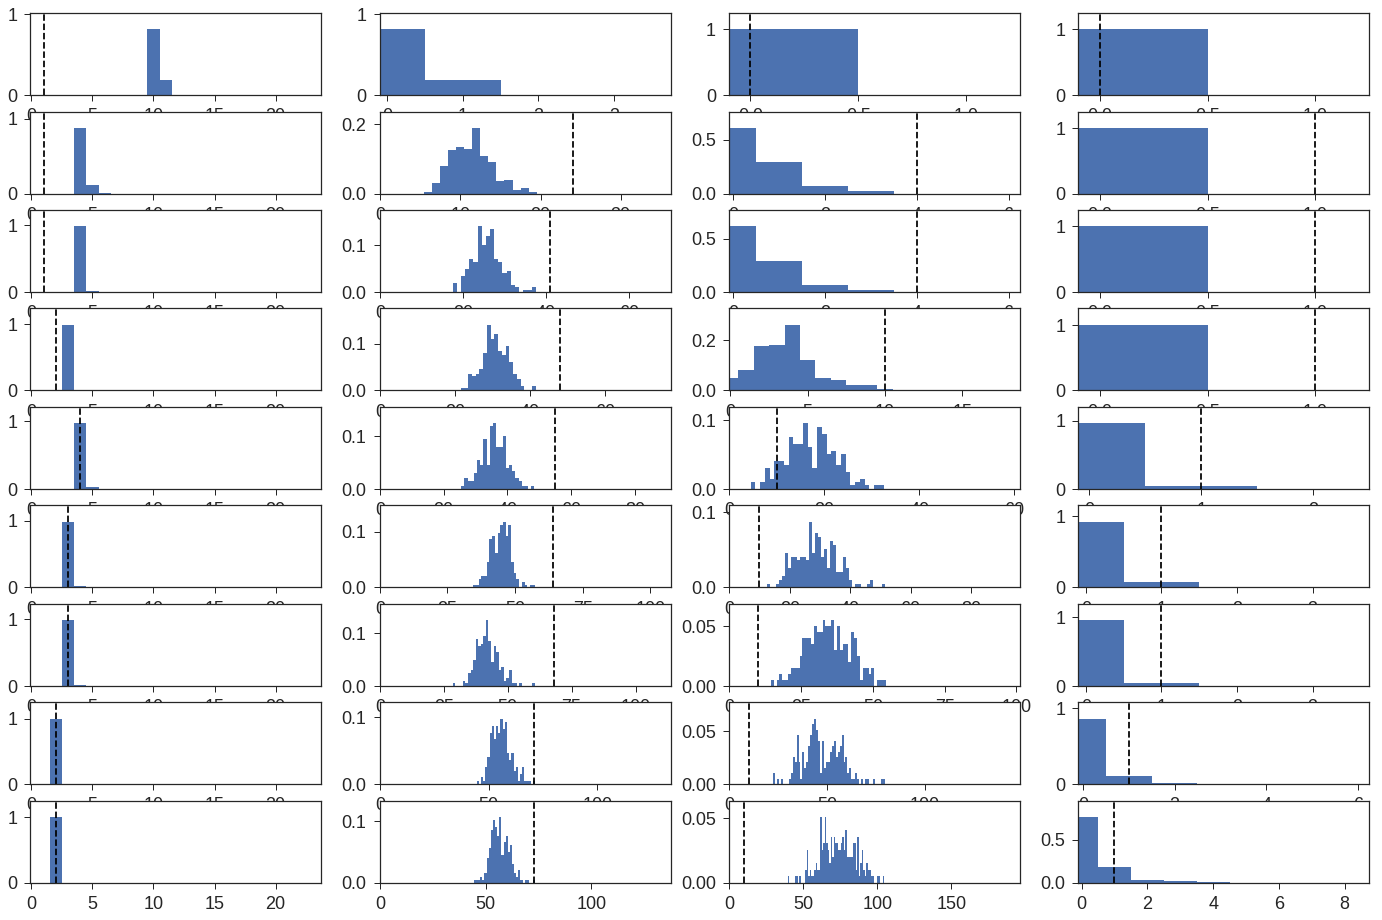

In [69]:
f, axs = plt.subplots(9, 4,figsize=(24, 16))
betti_num = 3
bettis = [0,1,2,3]
stim = 'L_40k'
my = 0
timeinds = np.arange(ntimes)[1:]
for betti_num in bettis:
    nmaxyt = 0
    nmaxxt = 0
    bettiax = axs.flatten()[4*(timeinds-1) + betti_num]
    for ax, t in zip(bettiax, timeinds):
        bettivals = bc_tavg[stim][:, t, 0]
   
        #final_bettis = stim_betticurve_dict[stim][-1]
        b = bettivals[betti_num]
        ax.plot([b, b], [0, 100], 'k--')
        print(t)
        (nmaxy, nmaxx) = plot_scm_distrib(stim_scm_dict[t], betti_num, ax=ax, align='left', histtype='stepfilled')
        nmaxyt = np.amax([nmaxy, nmaxyt])
        nmaxyt = nmaxy
        nmaxxt = np.amax([nmaxx, nmaxxt])
        print(nmaxyt)

    #ax.set_title(stim)
    
        ax.set_xlim([-0.1, 1.25*nmaxxt])
        ax.set_ylim([0, 1.25*nmaxyt])
        ax.tick_params(labelsize=18)
plt.savefig(os.path.join(figsavepth, 'SCMControlB1083_betti_stimL_10timepts.eps'.format(betti_num)))

In [16]:
stim_scm_dict.keys()

dict_keys([])

In [61]:
stim_scm_dict[6][:, 0, 2]

array([ 27.,  30.,  20.,  34.,  29.,  23.,  32.,  34.,  33.,  34.,  27.,
        27.,  27.,  25.,  28.,  31.,  21.,  35.,  30.,  23.,  32.,  39.,
        34.,  30.,  35.,  34.,  38.,  47.,  51.,  40.,  27.,  20.,  24.,
        -1.,  36.,  30.,  24.,  -1.,  34.,  34.,  19.,  32.,  35.,  28.,
        26.,  36.,  13.,  17.,  24.,  31.,  32.,  23.,  30.,  25.,  38.,
        28.,  29.,  33.,  27.,  28.,  27.,  30.,  32.,  38.,  42.,  26.,
        35.,  32.,  21.,  27.,  39.,  32.,  -1.,  27.,  35.,  25.,  33.,
        35.,  26.,  39.,  33.,  30.,  32.,  25.,  34.,  33.,  29.,  27.,
        29.,  39.,  20.,  21.,  27.,  20.,  29.,  24.,  21.,  19.,  21.,
        36.,  32.,  19.,  23.,  22.,  21.,  -1.,  22.,  26.,  19.,  22.,
        31.,  34.,  46.,  29.,  34.,  29.,  17.,  43.,  29.,  29.,  28.,
        38.,  37.,  30.,  25.,  26.,  28.,  22.,  37.,  28.,  19.,  21.,
        38.,  34.,  31.,  31.,  28.,  25.,  19.,  18.,  22.,  31.,  23.,
        29.,  47.,  27.,  19.,  26.,  37.,  27.,  3